In [2]:
import yfinance as yf 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import norm

In [3]:
ticker = "AI.PA"
start = "2024-01-01"
end = "2024-11-19"
dt = '1d'
data = yf.download(ticker, start=start, end=end,interval=dt)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AI.PA,AI.PA,AI.PA,AI.PA,AI.PA
Date,,,,,
2024-01-02,156.259216,158.867999,154.257957,158.117536,562469
2024-01-03,153.632553,156.116256,152.846340,156.044787,683417
2024-01-04,153.721893,153.954178,152.917821,153.400264,565257
2024-01-05,152.488983,153.310931,151.309671,152.774877,519433
2024-01-08,152.989288,153.132228,151.702757,152.095871,419873


1) Estimation sigma,rendement 

In [10]:
def get_yield(df):
    df.columns = df.columns.get_level_values(0)
    df['Spot'] = df['Close']
    df['log_return'] =  np.log(df['Spot'] / df['Spot'].shift(1))
    df = df.dropna(subset = ['log_return'])
    return df

get_yield(data)

Price,Close,High,Low,Open,Volume,Spot,log_return
Date,,,,,,,
2024-01-03,153.632553,156.116256,152.846340,156.044787,683417,153.632553,-0.016953
2024-01-04,153.721893,153.954178,152.917821,153.400264,565257,153.721893,0.000581
2024-01-05,152.488983,153.310931,151.309671,152.774877,519433,152.488983,-0.008053
2024-01-08,152.989288,153.132228,151.702757,152.095871,419873,152.989288,0.003276
2024-01-09,152.756989,153.096493,152.095870,153.042883,430997,152.756989,-0.001520
...,...,...,...,...,...,...,...
2024-11-12,159.580002,163.240005,159.580002,162.380005,957769,159.580002,-0.025490
2024-11-13,160.979996,163.399994,159.740005,161.639999,752386,160.979996,0.008735
2024-11-14,162.440002,162.660004,160.080002,161.339996,833918,162.440002,0.009029


In [13]:
def calc_nu(df) : 
    n = len(df)
    dt = 1/252

    return (1/(n*dt))*(df['log_return'].sum())

def vol(df) : 
    n = len(df)
    dt = 1/252
    nu = calc_nu(df)
    return np.sqrt((1/((n-1)*dt))*((df['log_return']-nu*dt)**2).sum())

def yield_rate_vol (df): 
    return [calc_nu(data),vol(df),calc_nu(df)-(1/2)*vol(df)**2]

yield_ = yield_rate_vol (data)
yield_

[0.027926989010470166, 0.18450325737616408, 0.010906263019262643]

In [15]:
def complete_years(data):
    # Obtenir la liste des années dans l'ordre
    min_year, max_year = min(data.keys()), max(data.keys())
    for year in range(min_year, max_year + 1):
        if year not in data:
            data[year] = data[year - 1]
    return dict(sorted(data.items()))


def rf_rate(year):
    df = pd.read_csv('ECB_Data.csv', sep=';')
    df = df[['YEAR', 'RATE']]
    df_pivot = df.groupby(by='YEAR', as_index=False).mean()
    dic_rate = complete_years(dict(zip(list(df_pivot['YEAR']), list(df_pivot['RATE']))))
    if year in dic_rate.keys():
        return dic_rate[year]
    else:
        return 'Wrong year'



In [16]:
def black_scholes(S, K, T, r, sigma, option_type="call"):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == "call":
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Type d'option non reconnu. Utilisez 'call' ou 'put'.")
    
    return price

# Paramètres de base
S = data['Close'].iloc[0]        
K = data['Close'].iloc[10]   # cette valeur est choisie complétement arbitrairement
T = 3     
# On prend une maturité de trois ans et on suppose que le taux sans risque n'évoluera pas pendant cette période, ni qu'il y aura des tombées de dividende
r = rf_rate(2024)*10**-2      
sigma = vol(data)   


Simulation Monte Carlo

In [18]:
def monte_carlo_option_pricing(S0, K, T, r, sigma, option_type='call', num_simulations=10000):
    discount_factor = np.exp(-r * T)  
    
    Z = norm.rvs(0, 1, num_simulations) 
    final_prices = S0* np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    

    if option_type == 'call':
        payoffs = np.maximum(final_prices - K, 0)
    elif option_type == 'put':
        payoffs = np.maximum(K - final_prices, 0)
    else:
        raise ValueError("option_type doit être 'call' ou 'put'")

    option_price = discount_factor * np.mean(payoffs)
    variance= np.var(payoffs)
    std_dev = np.sqrt(variance / num_simulations)
    
    return [option_price,std_dev]

num_simulations  = np.logspace(1,5,num = 100, dtype=int)
simul = np.array([monte_carlo_option_pricing(S, K, T, r, sigma, option_type='call', num_simulations=num) for num in num_simulations])
MC_list = simul[:,0]

bs = black_scholes(S, K, T, r, sigma, option_type="call")
upper = simul[:,0] + 1.96 * simul[:,1]
lower = simul[:,0] - 1.96 * simul[:,1]

bs_ = [bs for _ in num_simulations]

MC = monte_carlo_option_pricing(S, K, T, r, sigma, option_type='call', num_simulations=100000)
print (f"Monte Carlo Call : {MC[0]} ,     Black_Scholes Call : {bs}")

Monte Carlo Call : 27.930184643050495 ,     Black_Scholes Call : 27.964018632768557


Plot Monte-Carlo :

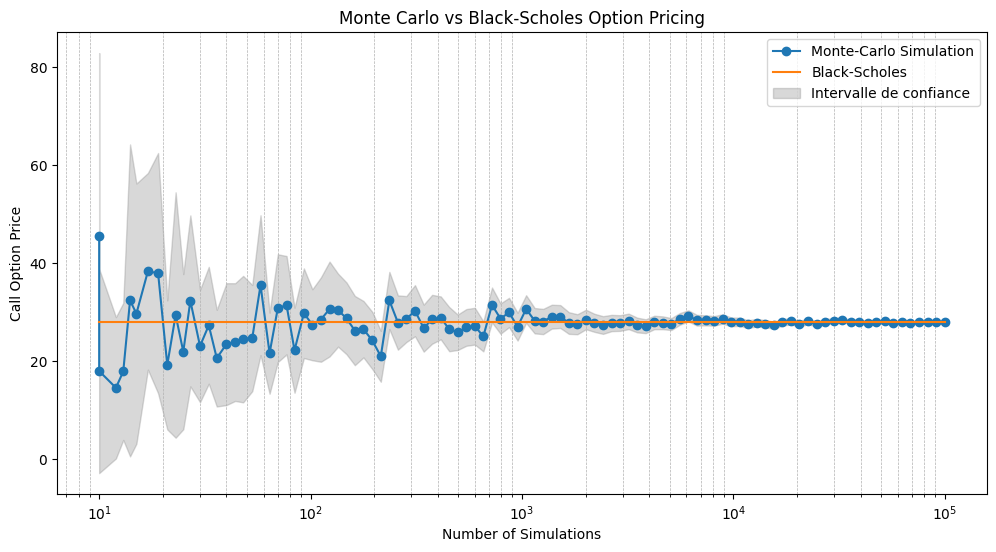

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(num_simulations, MC_list, label='Monte-Carlo Simulation', marker='o')
plt.plot(num_simulations, bs_, label='Black-Scholes', linestyle='-')
plt.fill_between(num_simulations, lower, upper, color='gray', alpha=0.3, label="Intervalle de confiance")
plt.xlabel("Number of Simulations")
plt.ylabel("Call Option Price")
plt.title("Monte Carlo vs Black-Scholes Option Pricing")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xscale('log')
plt.legend()
plt.grid()
plt.show()

Pour un grand nombre de simulation le prix de Monte-Carlo tend bien vers l'estimation du modèle de Black & Scholes

**3)**

Ici, nous utilisons la méthode du **Control Variate** pour réduire la variance des estimations du prix d'une option. L'idée est :  
1) De calculer le **payoff** de l'option en simulant des prix finaux à l'aide de la distribution normale standard pour \( Z \).  
2) D'introduire un **varié de contrôle** basé sur la corrélation entre les payoffs et les prix simulés. Cette variable est ajusté en fonction du paramètre \( \beta \), qui est calculé comme le ratio de la covariance entre les payoffs actualisés et les prix finaux, sur la variance des prix finaux.  
3) On utilise ce varié de contrôle pour ajuster les payoffs et obtenir une estimation du prix de l'option avec une **réduction de la variance**. Le calcul de l'écart-type est effectué pour la méthode avec et sans le varié de contrôle, permettant de comparer leur efficacité.

In [11]:
def monte_carlo_option_pricing_cv(S0, K, T, r, sigma, option_type='call', num_simulations=10000):
    discount_factor = np.exp(-r * T)  
    
    Z = norm.rvs(0, 1, num_simulations) 
    final_prices = S0* np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    mean_price = S0* np.exp(r * T)

    if option_type == 'call':
        payoffs = np.maximum(final_prices - K, 0)
    elif option_type == 'put':
        payoffs = np.maximum(K - final_prices, 0)
    else:
        raise ValueError("option_type doit être 'call' ou 'put'")
    beta = np.cov(payoffs*np.exp(-r*T),final_prices)[0][1]/np.var(final_prices)
    payoff_control_variate = payoffs-beta*(final_prices-mean_price)
    option_price = discount_factor * np.mean(payoff_control_variate)
    variance_control_variate = np.var(payoff_control_variate)
    std_dev = np.sqrt(variance_control_variate / num_simulations)
    return [option_price,std_dev]

monte_carlo_option_pricing_cv(S, K, T, r, sigma, option_type='call', num_simulations=10000)

[28.2290608370766, 0.15416268585589354]

In [12]:
simul_control_var = np.array([monte_carlo_option_pricing_cv(S, K, T, r, sigma, option_type='call', num_simulations=num) for num in num_simulations])
# pour avoir une estimation de l'écart type, on prend l'estimation pour le max de simul, on la multiplie par sqrt(nb simulation) pour normaliser, et on divise par le nombre réel de simulation
upper_cv = simul_control_var[:,0] + 1.96 * simul_control_var[:,1]
lower_cv = simul_control_var[:,0] - 1.96 * simul_control_var[:,1]

Plot Control Variate : 

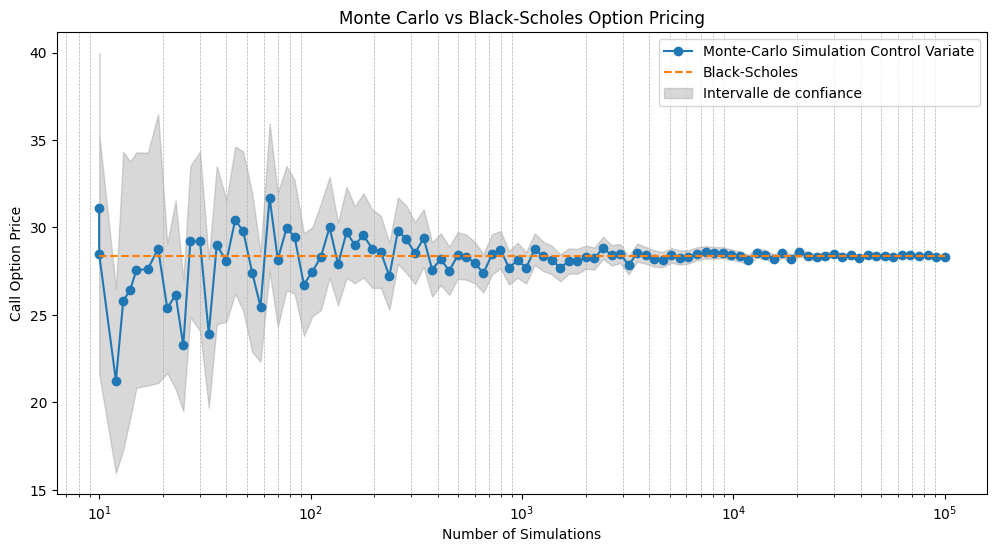

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(num_simulations, simul_control_var[:,0], label='Monte-Carlo Simulation Control Variate', marker='o')
plt.plot(num_simulations, bs_, label='Black-Scholes', linestyle='--')
plt.fill_between(num_simulations, lower_cv, upper_cv, color='gray', alpha=0.3, label="Intervalle de confiance")
plt.xlabel("Number of Simulations")
plt.ylabel("Call Option Price")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.title("Monte Carlo vs Black-Scholes Option Pricing")
plt.xscale('log')
plt.legend()
plt.grid()
plt.show()

On implémente la méthode d'**Importance sampling**  pour estimer le prix d'une option. L'idée est : 
1) de biaiser la distribution des variables simulées `Z`  (issues d'une distribution normale standard) en les tirant d'une distribution  ` N(shift, 1)`  , où le paramètre `shift` favorise les trajectoires les plus significatives pour le payoff. => On le prend par défaut à 1 (à la monnaie), le but est d'éviter une non convergence de l'algorithme ou une mauvaise réductuon de la variance 
2) Un facteur de pondération, le **likelihood ratio**, est appliqué pour corriger ce biais.

In [14]:
def monte_carlo_option_pricing_is(S0, K, T, r, sigma, option_type='call', num_simulations=10000, shift=1.0):
    discount_factor = np.exp(-r * T)
    
    # Importance sampling: modifier la distribution de Z
    Z_shifted = norm.rvs(shift, 1, num_simulations)  # Distribution normale centrée en "shift"
    final_prices = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z_shifted)


    # Calcul des payoffs
    if option_type == 'call':
        payoffs = np.maximum(final_prices - K, 0)
    elif option_type == 'put':
        payoffs = np.maximum(K - final_prices, 0)
    else:
        raise ValueError("option_type doit être 'call' ou 'put'")
    
    # Facteur de correction pour le biais introduit
    likelihood_ratio = np.exp(-0.5 * (Z_shifted**2 - (Z_shifted - shift)**2))
    weighted_payoffs = payoffs * likelihood_ratio
    
    # Calcul du prix avec importance sampling
    option_price = discount_factor * np.mean(weighted_payoffs)
    
    # Calcul de l'écart-type
    variance_weighted = np.var(weighted_payoffs * discount_factor)
    std_dev = np.sqrt(variance_weighted / num_simulations)

    return [option_price, std_dev]
monte_carlo_option_pricing_is(S, K, T, r, sigma, option_type='call', num_simulations=10000)

[28.199763157834127, 0.1317394160288023]

In [15]:
simul_importance_sampling = np.array([monte_carlo_option_pricing_is(S, K, T, r, sigma, option_type='call', num_simulations=num,shift=1) for num in num_simulations])
upper_is = simul_importance_sampling[:,0] + 1.96 * simul_importance_sampling[:,1]
lower_is = simul_importance_sampling[:,0] - 1.96 * simul_importance_sampling[:,1]

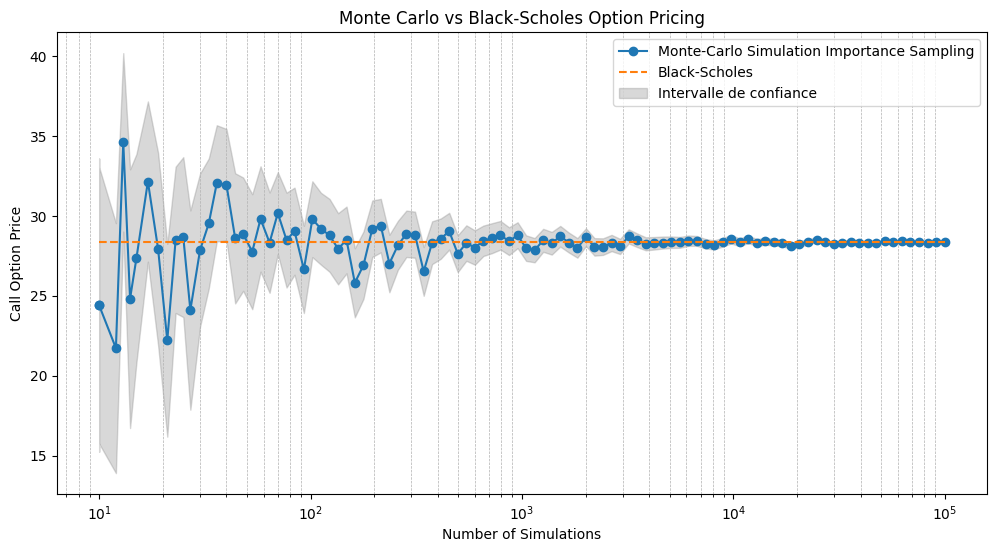

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(num_simulations, simul_importance_sampling[:,0], label='Monte-Carlo Simulation Importance Sampling', marker='o')
plt.plot(num_simulations, bs_, label='Black-Scholes', linestyle='--')
plt.fill_between(num_simulations, lower_is, upper_is, color='gray', alpha=0.3, label="Intervalle de confiance")
plt.xlabel("Number of Simulations")
plt.ylabel("Call Option Price")
plt.title("Monte Carlo vs Black-Scholes Option Pricing")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xscale('log')
plt.legend()
plt.grid()
plt.show()

pour comparer les deux convergence on va comparer l'evolution de la variance pour les deux cas 

In [17]:
def comparison_MC_euro_CV(S0, K, T, r, sigma, option_type='call', num_simulations=10000,shift=1.0):
    discount_factor = np.exp(-r * T)  

    #Control Variate, MC
    Z = norm.rvs(0, 1, num_simulations) 
    final_prices1 = S0* np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    mean_price = S0* np.exp(r * T)

    #Importance Sampling
    Z_shifted = norm.rvs(shift, 1, num_simulations)  
    final_prices2 = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z_shifted)


    if option_type == 'call':
        payoffs1 = np.maximum(final_prices1 - K, 0)
        payoffs2 = np.maximum(final_prices2 - K, 0)
    elif option_type == 'put':
        payoffs1 = np.maximum(K - final_prices1, 0)
        payoffs2 = np.maximum(K - final_prices2, 0)
    else:
        raise ValueError("option_type doit être 'call' ou 'put'")

    beta = np.cov(payoffs1*np.exp(-r*T),final_prices1)[0][1]/np.var(final_prices1)
    payoff_control_variate = payoffs1-beta*(final_prices1-mean_price)


    likelihood_ratio = np.exp(-0.5 * (Z_shifted**2 - (Z_shifted - shift)**2))
    weighted_payoffs = payoffs2 * likelihood_ratio
    
    variance =np.var(payoffs1)
    variance_weighted_is = np.var(weighted_payoffs * discount_factor)
    variance_control_variate = np.var(payoff_control_variate)

    std_dev = np.sqrt(variance/ num_simulations)
    std_dev_is = np.sqrt(variance_weighted_is / num_simulations)
    std_dev_cv = np.sqrt(variance_control_variate / num_simulations)
    
    return [std_dev,std_dev_cv,std_dev_is]
cv_vc_no = np.array([comparison_MC_euro_CV(S, K, T, r, sigma, option_type='call', num_simulations=num) for num in num_simulations])

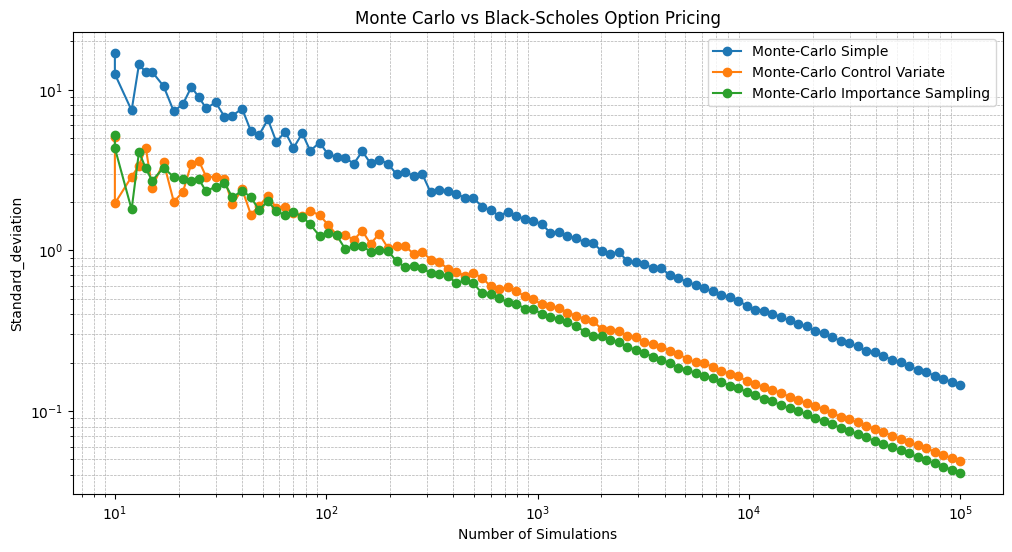

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(num_simulations, cv_vc_no, label=['Monte-Carlo Simple','Monte-Carlo Control Variate','Monte-Carlo Importance Sampling'], marker='o')
plt.xlabel("Number of Simulations")
plt.ylabel("Standard_deviation")
plt.title("Monte Carlo vs Black-Scholes Option Pricing")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

On remarque que comme anticipé, les méthodes de réduction de variance permettent pour toute simulation d'atteindre une variance plus faible. Ce qui induit une convergence plus rapide vers le prix de l'option, on remarque en revanche que pour des valeurs aberrante du shift, que la simultation Monte Carlo importance sampling ne convergera pas. 

***4) Passons désormais à la simulation d'options exotiques***, Nous nous interesserons ici aux options Barrière, Asiatiques et Américaines, on choisira la méthode de réduction de variance control variate pour son côté indépendant du shift de départ. 

Pour simuler ses prix il va 

In [19]:
def simulate_brownian_motion(T, n, seed=None): 
    if seed is not None:
        np.random.seed(seed)
    time_steps = np.linspace(0, T, n + 1)  # Points de temps
    delta_t = T / n                        # Pas de temps
    # Génération des incréments en utilisant scipy.stats.norm
    increments = norm.rvs(loc=0, scale=np.sqrt(delta_t), size=n, random_state=seed)
    # Construction du mouvement brownien
    B_t = np.concatenate(([0], np.cumsum(increments)))
    return time_steps, B_t

In [21]:
def monte_carlo_option_pricing_exo(S0, K, T, r, sigma, option_type='call', num_simulations=10000, num_steps=252, exo_type='A'):
    dt = T / num_steps  
    discount_factor = np.exp(-r * T)  
    
    mean_price = S0 * np.exp(r * T)
    
    prices = np.zeros((num_simulations, num_steps + 1))
    prices[:, 0] = S0

    # Simulation des prix de l'actif sous-jacent
    for t in range(1, num_steps + 1):
        Z = norm.rvs(0, 1, num_simulations)
        prices[:, t] = prices[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    
    final_prices = prices[:, -1]

    # Option Américaine (Call et Put)
    if exo_type == 'A':
        payoffs = np.zeros(num_simulations)
        
        for i in range(num_simulations):
            option_value = np.zeros(num_steps + 1)
            # Payoff à la maturité
            if option_type == 'call':
                option_value[-1] = np.maximum(final_prices[i] - K, 0)
            elif option_type == 'put':
                option_value[-1] = np.maximum(K - final_prices[i], 0)
            else:
                raise ValueError("option_type doit être 'call' ou 'put'")
            
            # Simulation backward : on calcule la valeur de l'option à chaque étape de temps
            for t in range(num_steps - 1, -1, -1):  # On remonte du dernier au premier pas de temps
                # Estimation de la valeur de continuation en actualisant la valeur au temps t+1
                continuation_value = np.exp(-r * dt) * option_value[t + 1]
                
                # Payoff immédiat : valeur si on exerce l'option immédiatement
                if option_type == 'call':
                    exercise_value = np.maximum(prices[i, t] - K, 0)
                elif option_type == 'put':
                    exercise_value = np.maximum(K - prices[i, t], 0)
                
                # La valeur de l'option au temps t est le maximum entre la valeur de continuation et le payoff immédiat
                option_value[t] = max(exercise_value, continuation_value)

            payoffs[i] = option_value[0]  # On récupère la valeur de l'option au temps 0

    # Calcul du prix de l'option
    option_price = discount_factor * np.mean(payoffs)
    
    # Si on souhaite utiliser le Control Variate pour réduire la variance
    mean_price = S0 * np.exp(r * T) 
    beta = np.cov(payoffs * np.exp(-r * T), final_prices)[0][1] / np.var(final_prices)
    payoff_control_variate = payoffs - beta * (final_prices - mean_price)
    option_price = discount_factor * np.mean(payoff_control_variate)
    
    # Calcul de l'écart-type avec Control Variate
    variance_control_variate = np.var(payoff_control_variate)
    std_dev = np.sqrt(variance_control_variate / num_simulations)

    return option_price, std_dev

# Exemple d'utilisation
S = data['Close'].iloc[0]        
K = data['Close'].iloc[10]         
T = 3      
r = rf_rate(2024)*10**-2      
sigma = vol(data)   
num_simulations = 10000  
num_steps = 252  

# Option américaine de type call
price_call, std_dev_call = monte_carlo_option_pricing_exo(S, K, T, r, sigma, option_type='call', num_simulations=num_simulations, exo_type='A')
print(f"Option Américaine Call : Prix = {price_call}, Ecart-type = {std_dev_call}")

# Option américaine de type put
price_put, std_dev_put = monte_carlo_option_pricing_exo(S, K, T, r, sigma, option_type='put', num_simulations=num_simulations, exo_type='A')
print(f"Option Américaine Put : Prix = {price_put}, Ecart-type = {std_dev_put}")


Option Américaine Call : Prix = 45.085127776507804, Ecart-type = 0.20423232975006347
Option Américaine Put : Prix = 24.146241663029233, Ecart-type = 0.13624109692557107


**Remarque** : ce resultat nous rassure :le prix du call américain déterminé ici est bien supérieur au call européen déterminé précédemment

In [22]:
num_simulations  = np.logspace(1,5,num = 20, dtype=int)

In [25]:
simul_american_cv = np.array([monte_carlo_option_pricing_exo(S, K, T, r, sigma, option_type='call', num_simulations=num, exo_type='A') for num in num_simulations])
upper_acv = simul_american_cv[:,0] + 1.96 * (simul_american_cv[:,1])
lower_acv = simul_american_cv[:,0] - 1.96 * (simul_american_cv[:,1])

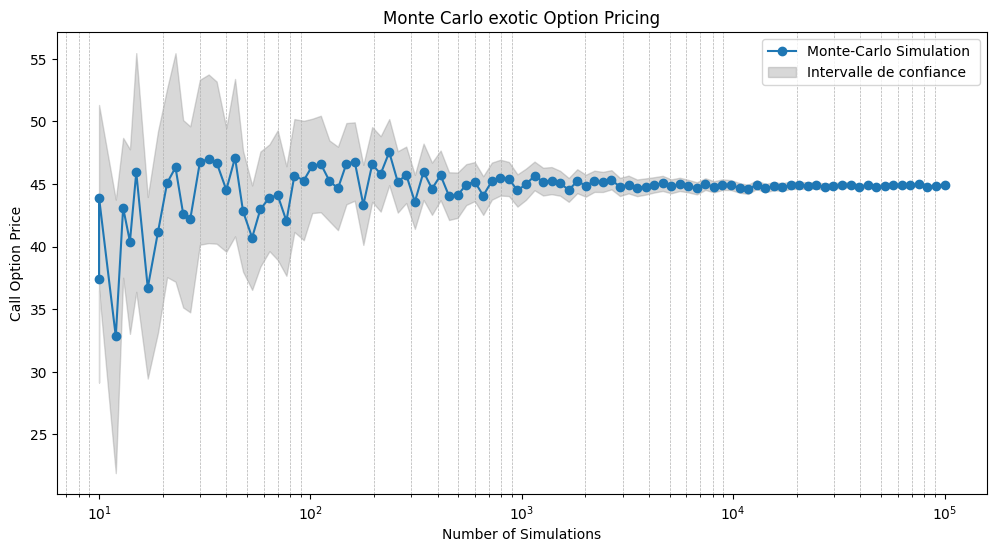

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(num_simulations, simul_american_cv[:,0], label='Monte-Carlo Simulation ', marker='o')
plt.xlabel("Number of Simulations")
plt.ylabel("Call Option Price")
plt.title("Monte Carlo exotic Option Pricing")
plt.fill_between(num_simulations, lower_acv, upper_acv, color='gray', alpha=0.3, label="Intervalle de confiance")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xscale('log')
plt.legend()
plt.grid()
plt.show()